In [17]:
import pandas as pd
import tensorflow as tf
import pickle
import numpy as np
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [18]:
with open('data/lges_ttl_pickle_v2.1.pkl', 'rb') as file:
    data = pickle.load(file)

with open('data/col_info_ttl_df_v1.pkl', 'rb') as file:
    col_info = pickle.load(file)


---
#### No.1 : JUDGE 넣고 학습 or JUDGE 빼고 학습

In [19]:
df = data['edge_finalvision']
df = pd.concat([df[['chunk_no', 'DATE_ms', 'vision_LOT-ID']],df[col_info.value[:4]], df[col_info.judge[:4]]], axis = 1)

map_dict = {'OK' : 0, 'NG' : 1}
for col in df.columns[-4:]:
    df[col] = df[col].map(map_dict)

---
#### No.2 : 날짜 기준으로 쪼개자. 
#### No.3 : chunk길이 긴것만 뽑자. 

In [20]:
### 하루기준이다. 

chunk_no_min = df[(df.DATE_ms >= '2021-11-22') & (df.DATE_ms <'2021-11-24')].chunk_no.min()
chunk_no_max = df[(df.DATE_ms >= '2021-11-22') & (df.DATE_ms <'2021-11-24')].chunk_no.max()

df = df[(df['chunk_no'] >= chunk_no_min) & (df['chunk_no'] <= chunk_no_max)]

In [21]:
df['data_diff'] = None
df['data_diff'][1: ] = np.cumsum(np.diff(df.DATE_ms).astype('float'))
df['data_diff'][0] = 0

df['DATE_ms'] = df['data_diff']
df = df.drop('data_diff', axis = 1)

In [22]:
col = ['vision_CS_1', 'vision_CS_2', 'vision_CS_3', 'vision_CS_4', 'vision_CS_1-OK/NG', 'vision_CS_2-OK/NG', 'vision_CS_3-OK/NG', 'vision_CS_4-OK/NG']

scaler = {}
for i in range(4):
    scaler['scaler'+str(i)]  = MinMaxScaler()
    scaler['scaler'+str(i)].fit(df[[col[i]]])
    df[col[i]] = scaler['scaler'+str(i)].transform(df[[col[i]]])

In [23]:
# self-supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [24]:
### chunk_no 별로 for문 돌려야 함. 

data = {}

for i in range(len(df.chunk_no.unique())):
    df_tmp = df[df.chunk_no==i][col]

    n_past = 8
    n_future = 2 
    n_features = 8

    agg = series_to_supervised(df_tmp, n_in = 8, n_out = 2, dropnan=True)
    train_X, train_y = agg.iloc[:, :-8*2], agg.iloc[:, -8*2:]

    # reshape input to be 3D [samples, timesteps, features]

    train_X = train_X.values.reshape((train_X.values.shape[0], n_past, n_features))
    train_y = train_y.values.reshape((train_y.values.shape[0], n_future, n_features))
    
    
    train_X = train_X[: - int(train_X.shape[0]*0.2)]
    val_X = train_X[-int(train_X.shape[0]*0.2) : ]
           
    train_y= train_y[: - int(train_y.shape[0]*0.2)]
    val_y = train_y[-int(train_y.shape[0]*0.2) : ]
    
    
    data['X_{}'.format(i)] = train_X
    data['y_{}'.format(i)] = train_y
    
    data['val_X_{}'.format(i)] = val_X
    data['val_y_{}'.format(i)] = val_y

---
#### Modelling

In [10]:
n_past = 8
n_future = 2 
n_features = 8

model_n_past = 8
model_n_future = 2 
model_n_features = 4

In [35]:
data['X_0'].shape

(16, 8, 8)

In [25]:
### seq2seq model 

### ok/ng input
auxiliary_input = tf.keras.layers.Input(shape=(n_past, model_n_features), name='aux_input')

### encoder
encoder_inputs = tf.keras.layers.Input(shape=(n_past, model_n_features))
encoder_l1 = tf.keras.layers.LSTM(8,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(8, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

### decoder
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.LSTM(8, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(8, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(model_n_features))(decoder_l2)

### RNN
aux_layer_output = tf.keras.layers.SimpleRNN(model_n_features, return_sequences = True)(auxiliary_input)
aux_output = aux_layer_output[:,-model_n_future:, :]

### cocnat
concat = tf.keras.layers.concatenate([decoder_outputs2, aux_output])

### model
model = tf.keras.models.Model(inputs = [encoder_inputs,auxiliary_input], outputs = [concat])

### compile
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber(), run_eagerly=True)


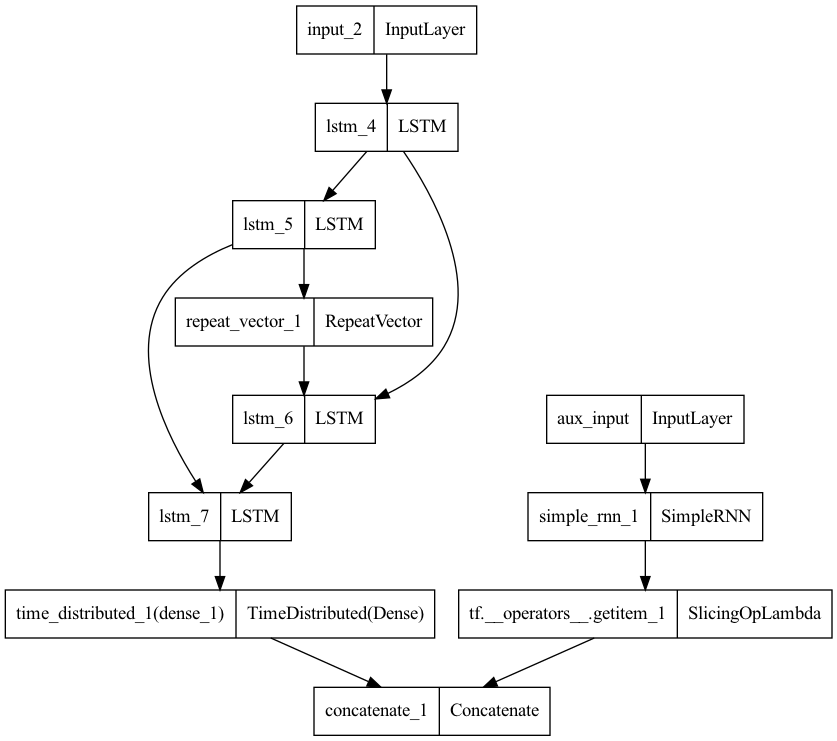

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [29]:
pd.DataFrame(data['X_0'][0])

,0,1,2,3,4,5,6,7
0,0.194258,0.285405,0.463280,0.542446,0.0,0.0,0.0,0.0
1,0.194258,0.285405,0.463280,0.542446,0.0,0.0,0.0,0.0
2,0.178417,0.225597,0.476744,0.581840,0.0,0.0,0.0,0.0
3,0.178417,0.225597,0.476744,0.581840,0.0,0.0,0.0,0.0
4,0.166678,0.208670,0.642799,0.594643,0.0,0.0,0.0,0.0
5,0.191712,0.298571,0.640963,0.622415,0.0,0.0,0.0,0.0
6,0.153242,0.232274,0.151163,0.662596,0.0,0.0,1.0,0.0
7,0.163708,0.208200,0.592411,0.665551,0.0,0.0,0.0,0.0


In [36]:
pd.DataFrame(data['X_1'][0])

,0,1,2,3,4,5,6,7
0,0.162718,0.233026,0.632395,0.645066,0.0,0.0,0.0,0.0
1,0.162718,0.233026,0.632395,0.645066,0.0,0.0,0.0,0.0
2,0.172406,0.299511,0.587311,0.639748,0.0,0.0,0.0,0.0
3,0.172406,0.299511,0.587311,0.639748,0.0,0.0,0.0,0.0
4,0.162506,0.260955,0.572827,0.665157,0.0,0.0,0.0,0.0
5,0.162506,0.260955,0.572827,0.665157,0.0,0.0,0.0,0.0
6,0.156425,0.218544,0.490004,0.607445,0.0,0.0,0.0,0.0
7,0.156425,0.218544,0.490004,0.607445,0.0,0.0,0.0,0.0


In [27]:
%%time

# tf.config.run_functions_eagerly(True)


### 전체 chunk에 대해 모두 학습하여 모델 1개로 배출
checkpoint_path = "seq2seq.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

for i in range(len(df.chunk_no.unique())):
    history=model.fit([data['X_{}'.format(i)][:,:,:4], data['X_{}'.format(i)][:,:,4:]],data['y_{}'.format(i)],
                      validation_data = ([data['val_X_{}'.format(i)][:,:,:4], 
                                          data['val_X_{}'.format(i)][:,:,4:]],
                                          data['val_y_{}'.format(i)]),
                      epochs=5, batch_size=10,verbose=0, \
                          callbacks = [cp_callback])
    
    print('chunk no is ' , i)
    
    if i == 3:
        break


Epoch 00001: saving model to seq2seq.ckpt

Epoch 00002: saving model to seq2seq.ckpt

Epoch 00003: saving model to seq2seq.ckpt

Epoch 00004: saving model to seq2seq.ckpt

Epoch 00005: saving model to seq2seq.ckpt
chunk no is  0

Epoch 00001: saving model to seq2seq.ckpt

Epoch 00002: saving model to seq2seq.ckpt

Epoch 00003: saving model to seq2seq.ckpt

Epoch 00004: saving model to seq2seq.ckpt

Epoch 00005: saving model to seq2seq.ckpt
chunk no is  1

Epoch 00001: saving model to seq2seq.ckpt

Epoch 00002: saving model to seq2seq.ckpt

Epoch 00003: saving model to seq2seq.ckpt

Epoch 00004: saving model to seq2seq.ckpt

Epoch 00005: saving model to seq2seq.ckpt
chunk no is  2

Epoch 00001: saving model to seq2seq.ckpt

Epoch 00002: saving model to seq2seq.ckpt

Epoch 00003: saving model to seq2seq.ckpt

Epoch 00004: saving model to seq2seq.ckpt

Epoch 00005: saving model to seq2seq.ckpt
chunk no is  3
CPU times: user 3min 45s, sys: 2.67 s, total: 3min 48s
Wall time: 3min 52s
